# Contexte

Ce NoteBook est celui utilisé pour entrainer le CNN via VGG16 sur les serveur EC2 de AWS. (serveur pxlarge) 

De nombreux essais ont été fait pour permettre d'arriver à la modéliser la classification des noms de baleines, ici il s'agit du fichier prenant en entrée le DataSet des classes ayant plus de 5 fichiers fournis.

## Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Librairies Keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras import layers
from keras import optimizers

# Model 
from keras.applications import VGG16

Using TensorFlow backend.


## Variables Utiles

In [3]:
rep_image = '/home/ubuntu/data/DATAS/'
rep_file_csv = '/home/ubuntu/data/NoteBook/input/'
rep_output = '/home/ubuntu/data/NoteBook/output/'

In [4]:
dir_train = rep_image + 'train_ter/'
#dir_train = rep_image + 'train_bis/'

dir_validation = dir_train
dir_test = dir_train

dir_prediction = rep_image + 'test/'

### CSV

In [ ]:
# Chargement du fichier initial 
dir_CSV_IN = '/home/ubuntu/data/CSV/'
file1 = dir_CSV_IN + 'train.csv'
df1 = pd.read_csv(file1)

# On filtre les classes ayant strictement plus de 5 images
t1 = df1.Id.value_counts()
l_representee = t1[t1.values>5].index

l_m_df = []
for name in l_representee:
    l_m_df.append(df1[df1.Id==name])

new_df = pd.concat(l_m_df)

### On sépare les données en Train (70 %) / Validation (15%) / Test (15%)
> On sépare en stratify pour s'assurer de ne pas manquer d'une classe dans un des ensembles

In [ ]:
from sklearn.model_selection import train_test_split

X_train_l, X_test_validation_l, _, _ = train_test_split(
    new_df, new_df, test_size=0.3, random_state=42, stratify=new_df.Id)

X_validation_l, X_test_l, _, _ = train_test_split(
    X_test_validation_l, X_test_validation_l, 
    test_size=0.5, random_state=42, stratify=X_test_validation_l.Id
)

X_train_l.to_csv(rep_file_csv + 'train_3_10.csv', index=False)
X_validation_l.to_csv(rep_file_csv + 'validation_3_10.csv', index=False)
X_test_l.to_csv(rep_file_csv + 'test_3_10.csv', index=False)

In [5]:
df_train = pd.read_csv(rep_file_csv + 'train_3_10.csv')
df_validation = pd.read_csv(rep_file_csv + 'validation_3_10.csv')
df_test = pd.read_csv(rep_file_csv + 'test_3_10.csv')

# Models

### Variables Globales

In [6]:
# BatchSize : 
train_batchsize = 32
validation_batchsize = 20

#image_size = 256
image_size = 224

### Model
> On lance le lancement du modèle par fonction.
Pour cela on utilise le VGG16 à partir des données d'imageNet

In [7]:
def prepare_model(image_size = 224, nb_classe=120):
    
    from keras.applications import VGG16
    #Nous chargeons le modèle VGG16 pré-entrainé
  
    #vgg_conv = VGG16(weights='imagenet', include_top=False, 
    #                 input_shape=(image_size, image_size, 3))
    vgg_conv = VGG16(weights='imagenet', include_top=False, 
                     input_shape=(image_size, image_size, 3))
    
    ### Nous allons entrainer uniquement les 4 plus haut niveaux 
    # Les autres restent freezé (pour ne pas les réentrainer
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False

    # Check the trainable status of the individual layers
    for layer in vgg_conv.layers:
        print(layer, layer.trainable)
        
    from keras import models
    from keras import layers
    from keras import optimizers

    # Create the model
    model = models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    #### Nombre de Classes : on met cela en paramètre !!!!!!!!
    #######model.add(layers.Dense(120, activation='softmax'))
    model.add(layers.Dense(nb_classe, activation='softmax'))

    # Show a summary of the model. Check the number of trainable parameters
    #####model.summary()
    
    return model

# Programme

## Les ImageDataGenerator qui réalisent les transformation sur les images

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
    ###brightness_range=[0.95, 1.05],
    brightness_range=[0.80, 1.2],
    zoom_range=[0.75, 1.25],
    #zoom_range=[0.85, 1.15]
)

#validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
#                                        height_shift_range=0.2,fill_mode='nearest',)


validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

##### Generators

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=dir_train,
    ###save_to_dir=dir_my_working,
    ###save_prefix='TRAIN',
    target_size=(image_size, image_size),
    batch_size=train_batchsize,
    ####color_mode='grayscale',
    class_mode='categorical',
    x_col='Image', 
    y_col='Id', 
    has_ext=True
)


Found 11943 images belonging to 634 classes.


In [10]:
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df_validation, 
    directory=dir_validation,
    ####save_to_dir=dir_my_working,
    #####save_prefix='VALID',
    target_size=(image_size, image_size),
    ######batch_size=train_batchsize,
    batch_size=validation_batchsize,
    #####color_mode='grayscale',
    class_mode='categorical',
    x_col='Image', 
    y_col='Id', 
    has_ext=True 
)

Found 2559 images belonging to 634 classes.


In [11]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory=dir_test,
    ####save_to_dir=dir_my_working,
    #####save_prefix='VALID',
    target_size=(image_size, image_size),
    batch_size=train_batchsize,
    #####color_mode='grayscale',
    class_mode='categorical',
    ######class_mode='categorical',
    ######class_mode=None,
    x_col='Image', 
    y_col='Id', 
    #######y_col=None, 
    has_ext=True 
)

Found 2560 images belonging to 634 classes.


### Avec GPU

In [2]:
import tensorflow as tf
sess = tf.Session()


In [13]:
tf.test.is_gpu_available()

True

In [14]:
%%time 

#NB_EPOCH = 10 
NB_EPOCH = 30
###NB_EPOCH = 30 

model_gpu = prepare_model(image_size=224, nb_classe=634)

model_gpu.compile(
    loss='categorical_crossentropy',
    ####optimizer=optimizers.RMSprop(lr=1e-4),
    optimizer=optimizers.SGD(lr=1e-4),
    metrics=['acc'])

history_gpu = model_gpu.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=NB_EPOCH,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    #workers = 1, 
    use_multiprocessing = True, 
    #######use_multiprocessing = False, 
    verbose=1,
    #verbose=1
)

# On sauvegarde le modèle 
model_gpu.save_weights(rep_output + "model_gpu2_3_10.h5")
model_gpu.save_weights(rep_output + "model_gpu2_weights_3_10.h5")

<keras.engine.input_layer.InputLayer object at 0x7f1e8d09cb00> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d09ca20> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d09c940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e8d09b780> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d09b240> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d099e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e8d098ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d098320> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d096da0> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d095ac8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e8d093dd8> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d093da0> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d091f28> False
<keras.layers.convolutional.Conv2D object at 0x7f1e8d090b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1e8d10fc88>

### On sauvegarde le dump de history_gpu.history en json 

In [15]:
import json

histo1 = json.dumps(history_gpu.history)
with open(rep_output+"3_10_history_gpu_history.json", "w") as f:
    f.write(histo1)

## Etablissement de l'accuracy des données de test

In [21]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory=dir_test,
    ####save_to_dir=dir_my_working,
    #####save_prefix='VALID',
    target_size=(image_size, image_size),
    batch_size=train_batchsize+1,
    class_mode='categorical',
    ######class_mode='categorical',
    ######class_mode=None,
    x_col='Image', 
    y_col='Id', 
    #######y_col=None, 
    has_ext=True 
)

Found 2560 images belonging to 634 classes.


In [26]:
%%time 

test_generator.reset()
STEP_SIZE_TEST=test_generator.n/test_generator.batch_size

prediction_1 = model_gpu.predict_generator(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)

78/77 [==============================] - 29s 367ms/step
CPU times: user 8.67 s, sys: 284 ms, total: 8.96 s
Wall time: 28.6 s


In [28]:
dict_class_indices = dict()
for k,v in zip(test_generator.class_indices.keys(), test_generator.class_indices.values()):
    dict_class_indices[v]=k

col_name = [dict_class_indices[x] for x in range(prediction_1.shape[1])]

df_prediction_1 = pd.DataFrame(prediction_1, columns=col_name, index=df_test.Image.values)
df_prediction_1['Real_Class_Name'] = df_test.Id.values
df_prediction_1['Real_Class_Id'] = [ test_generator.class_indices[x] for x in df_test.Id.values ]

## Sauvegarde des données de test prédites pour analyser et mesurer la performance du modèle

In [29]:
df_prediction_1.to_csv(rep_output+'3_10_DF_TEST_PREDICTION.csv', index=True)

## PREDICTION DES DONNEES CHALLENGE

On génère la prédiction des données du Challenge 

In [30]:
import os

df_predict = pd.DataFrame({'Image':os.listdir(dir_prediction)})

In [31]:
predict_datagen = ImageDataGenerator(rescale=1./255)

predict_generator = predict_datagen.flow_from_dataframe(
    dataframe=df_predict, 
    directory=dir_prediction,
    ####save_to_dir=dir_my_working,
    #####save_prefix='VALID',
    target_size=(image_size, image_size),
    batch_size=train_batchsize,
    ###############class_mode='categorical',
    ######class_mode='categorical',
    class_mode=None,
    x_col='Image', 
    ###############y_col='Id', 
    y_col=None, 
    has_ext=True 
)

Found 7960 images.


In [32]:
%%time 

predict_generator.reset()
STEP_SIZE_PREDICT=predict_generator.n/predict_generator.batch_size

prediction_challenge = model_gpu.predict_generator(
    predict_generator,
    steps=STEP_SIZE_PREDICT,
    verbose=1)

249/248 [==============================] - 81s 324ms/step
CPU times: user 1min 32s, sys: 0 ns, total: 1min 32s
Wall time: 1min 20s


In [33]:
df_prediction_challenge = pd.DataFrame(prediction_challenge, columns=col_name, index=df_predict.Image.values)


In [34]:
df_prediction_challenge.to_csv(rep_output+'3_10_DF_PREDICTION_CHALLENGE.csv', index=True)

## Graphes 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


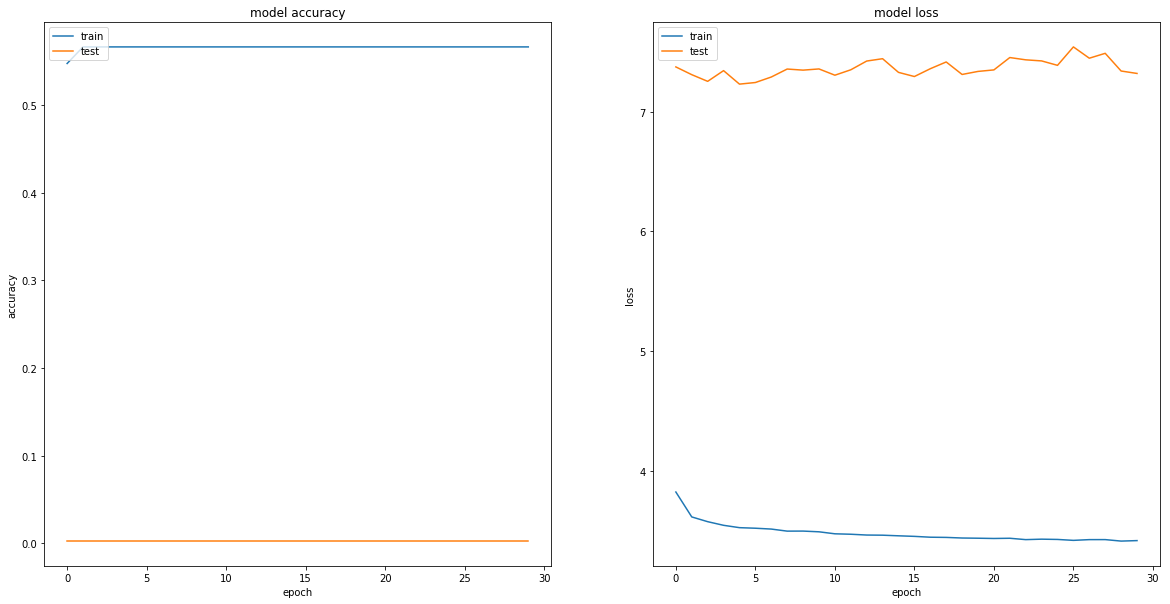

In [35]:
#list all data in history
plt.figure(figsize=(20, 10), )

plt.subplot(121)
print(history_gpu.history.keys())
# summarize history for accuracy
plt.plot(history_gpu.history['acc'])
plt.plot(history_gpu.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
# summarize history for loss
plt.plot(history_gpu.history['loss'])
plt.plot(history_gpu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()